# Testing Algorithm


#### Further References:


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import pm4py


sys.path.append("/app/backend")

from compositional_algorithm.combine_nets.combine_nets import MergeNets
from compositional_algorithm.compositional_algorithm import compositional_discovery
from compositional_algorithm.compositional_algorithm import discover
from compositional_algorithm.compositional_algorithm import generate_unique_id
from compositional_algorithm.compositional_algorithm import is_isomorphic
from compositional_algorithm.compositional_algorithm import is_net_valid
from compositional_algorithm.compositional_algorithm import is_refinement
from compositional_algorithm.compositional_algorithm import priority_identifier
from compositional_algorithm.interface_patterns.interface_patterns import (
    INTERFACE_PATTERNS,
)
from compositional_algorithm.transformations.transformations import TRANSFORMATIONS
from compositional_algorithm.transformations.transformations import PlaceTransformation
from compositional_algorithm.transformations.transformations import (
    TransitionTransformation,
)
from entropy_conformance.entropy_conformance import entropy_conformance

#### 0. Algorithm Input


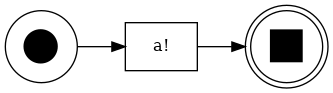

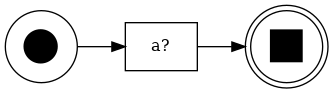

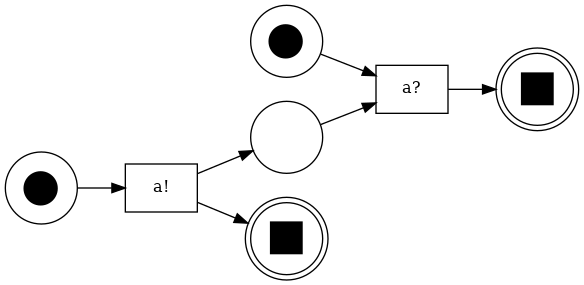

In [3]:
# define input path
log_path = "/app/backend/data_catalog/compositional_process_discovery_experiment_data/IP-1/IP-1_initial_log.xes"

# select algorithm
algorithm = pm4py.discover_petri_net_inductive
# algorithm = split_miner

# interface pattern
IP1 = INTERFACE_PATTERNS[0]
ip1_net_a1, ip1_initial_marking_a1, ip1_final_marking_a1 = IP1.get_net("A1")
pm4py.view_petri_net(ip1_net_a1, ip1_initial_marking_a1, ip1_final_marking_a1)
ip1_net_a2, ip1_initial_marking_a2, ip1_final_marking_a2 = IP1.get_net("A2")
pm4py.view_petri_net(ip1_net_a2, ip1_initial_marking_a2, ip1_final_marking_a2)
ip1_net = MergeNets.merge_nets(ip1_net_a1, ip1_net_a2)
initial_marking = MergeNets.merge_markings(
    ip1_initial_marking_a1,
    ip1_initial_marking_a2,
)
final_marking = MergeNets.merge_markings(ip1_final_marking_a1, ip1_final_marking_a2)
pm4py.view_petri_net(ip1_net, initial_marking, final_marking)

#### 1. Directly Discover with the given input


parsing log, completed traces ::   0%|          | 0/5000 [00:00<?, ?it/s]

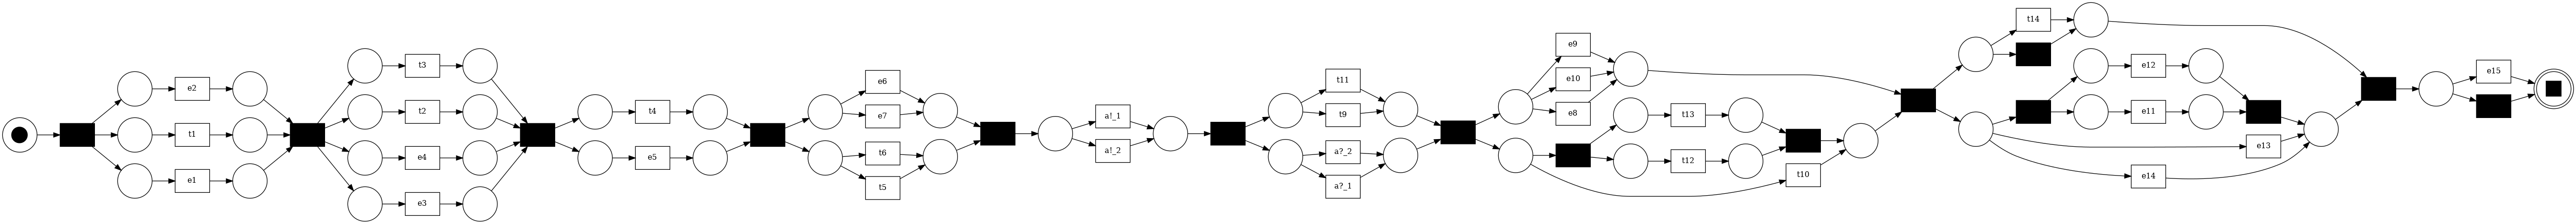

In [4]:
# discover by selected algorithm
net, initial_marking, final_marking = discover(log_path, algorithm)
pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

#### 2. Check Net is valid


In [5]:
# check helper functions works
assert is_net_valid(net, net) is True

#### 3. Check Nets are equal


In [6]:
# check net comparison works
assert is_isomorphic(net, net) is True

#### 4. Check ID Hash


In [7]:
assert generate_unique_id(net) == generate_unique_id(net)

#### 5. Check is Refinement


##### 5.1 Apply single refinement


refining at place p_50
[(<class 'compositional_algorithm.transformations.transformations.P1'>, p_50)]


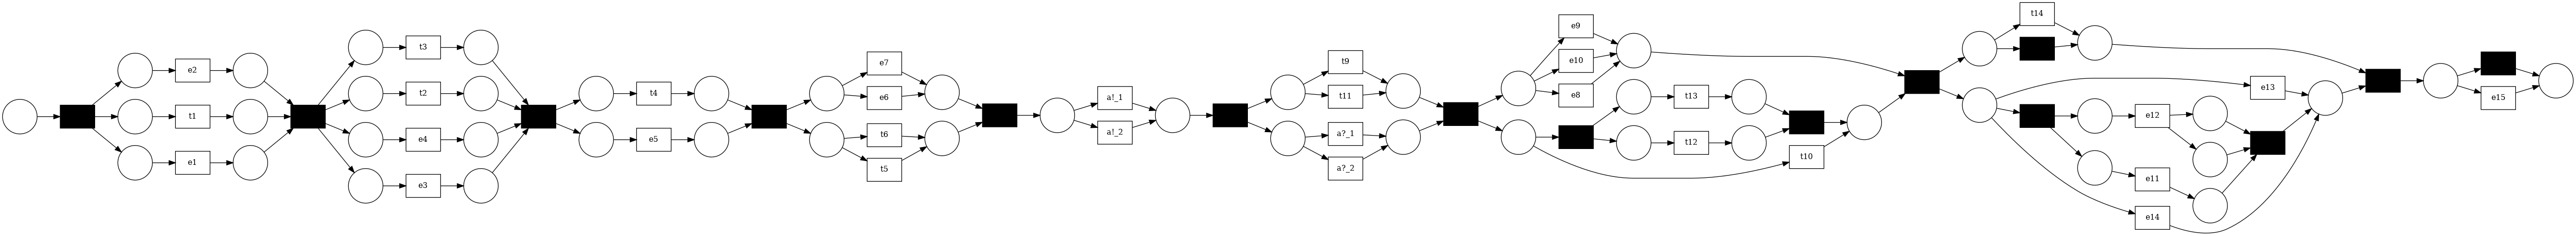

In [8]:
# sequence
transformation_sequence = []

# initial net
copy_refine_net = net.__deepcopy__()

# apply a P1 transformation
places = list(copy_refine_net.places)
P1 = TRANSFORMATIONS[0]
single_refined_net = P1.refine(places[2], copy_refine_net)
transformation_seq_element = (P1, places[2])
transformation_sequence.append(transformation_seq_element)

print(f"refining at place {places[2]}")  # noqa: T201
print(transformation_sequence)  # noqa: T201
pm4py.view_petri_net(single_refined_net)

In [9]:
print(priority_identifier(net, single_refined_net, transformation_sequence))

1.585732036721156


##### 5.2 Apply multiple refinements


[(<class 'compositional_algorithm.transformations.transformations.P1'>, p_A1_1), (<class 'compositional_algorithm.transformations.transformations.P3'>, p_A1_1), (<class 'compositional_algorithm.transformations.transformations.P4'>, p_A1_1), (<class 'compositional_algorithm.transformations.transformations.P1'>, p_A1_2), (<class 'compositional_algorithm.transformations.transformations.P3'>, p_A1_2), (<class 'compositional_algorithm.transformations.transformations.P4'>, p_A1_2), (<class 'compositional_algorithm.transformations.transformations.P2'>, (a!, 'a!')), (<class 'compositional_algorithm.transformations.transformations.P2'>, (t, 't')), (<class 'compositional_algorithm.transformations.transformations.P2'>, (t, 't'))]


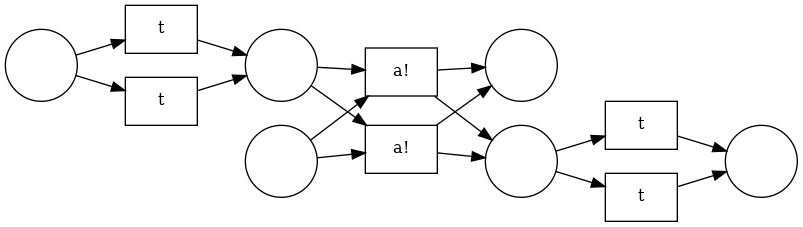

In [10]:
# sequence
transformation_sequence = []

# Make a deep copy of the original net
multiple_refined_net = ip1_net_a1.__deepcopy__()

# split in place and transition transformations
place_transformations = [
    t for t in TRANSFORMATIONS if isinstance(t(), PlaceTransformation)
]
transition_transformations = [
    t for t in TRANSFORMATIONS if isinstance(t(), TransitionTransformation)
]

# Note: branching logic: we need to apply all possible transformations
# for each place in the current net
for place in multiple_refined_net.places:
    # apply each possible place transformation
    for place_transformation in place_transformations:
        # Note: Deep copy of the current net before applying the transformation -> transformation change places & transitions and sets are immutable.
        net_copy = multiple_refined_net.__deepcopy__()
        transformed_net = place_transformation.refine(place, net_copy)
        transformation_seq_element = (place_transformation, place)
        transformation_sequence.append(transformation_seq_element)

        # Update multiple_refined_net to the latest transformed net
        multiple_refined_net = transformed_net

# for each transition in the current net
for transition in multiple_refined_net.transitions:
    # apply each possible transition transformation
    for transition_transformation in transition_transformations:
        # Note: ensures that subsequent transformations are applied to a fresh instance of the net.
        net_copy = multiple_refined_net.__deepcopy__()
        transformed_net = transition_transformation.refine(
            transition,
            net_copy,
        )
        transformation_seq_element = (transition_transformation, transition)
        transformation_sequence.append(transformation_seq_element)

    # Update multiple_refined_net to the latest transformed net
    multiple_refined_net = transformed_net

print(transformation_sequence)  # noqa: T201
pm4py.view_petri_net(multiple_refined_net, initial_marking, final_marking, format="png")

In [11]:
print(priority_identifier(net, multiple_refined_net, transformation_sequence))

3.412563483586404


In [12]:
# check if the net is a refinement
is_ref, path = is_refinement(net, net, TRANSFORMATIONS)
assert is_ref is True

2024-09-21 09:39:33,537 - INFO - The nets are initially isomorphic.


Processing Queue: 0it [00:00, ?it/s]2024-09-21 09:39:33,747 - INFO - Discovering new net (1 priority, 47 places, 46 transitions, 116 arcs).


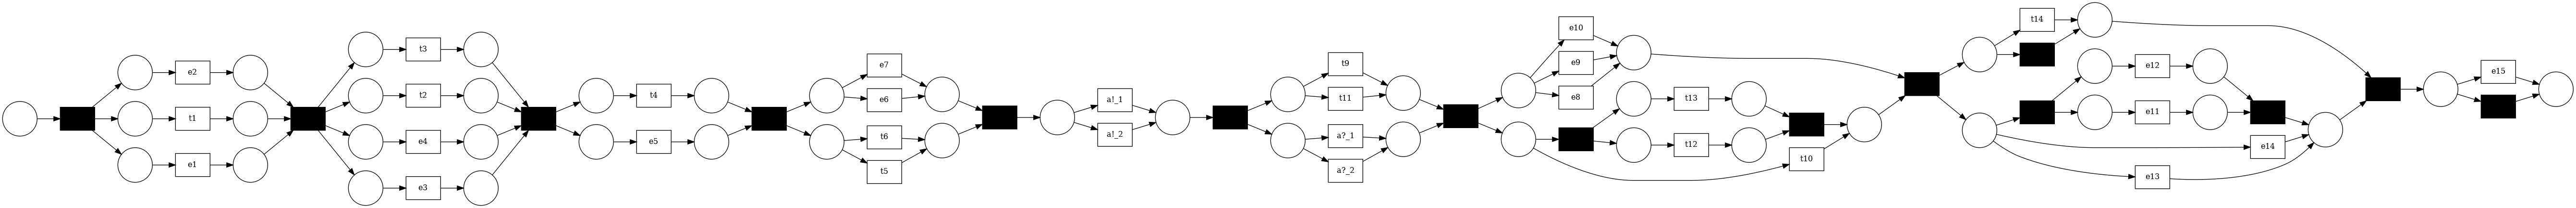

2024-09-21 09:39:34,858 - INFO - The nets are isomorphic (P) after [(<class 'compositional_algorithm.transformations.transformations.P1'>, p_52)].
Processing Queue: 1it [00:01,  1.11s/it]

Output: True [(<class 'compositional_algorithm.transformations.transformations.P1'>, p_52)]


In [13]:
assert not is_isomorphic(net, single_refined_net)

# check refinement algorithm
is_ref, path = is_refinement(net, single_refined_net, TRANSFORMATIONS)
print("Output:", is_ref, path)  # noqa: T201

Processing Queue: 0it [00:00, ?it/s]2024-09-21 09:39:35,029 - INFO - Discovering new net (4 priority, 2 places, 1 transitions, 2 arcs).


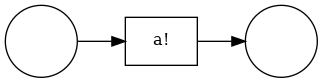

Processing Queue: 996it [00:04, 244.71it/s]2024-09-21 09:39:39,803 - INFO - Discovering new net (-2 priority, 6 places, 5 transitions, 15 arcs).


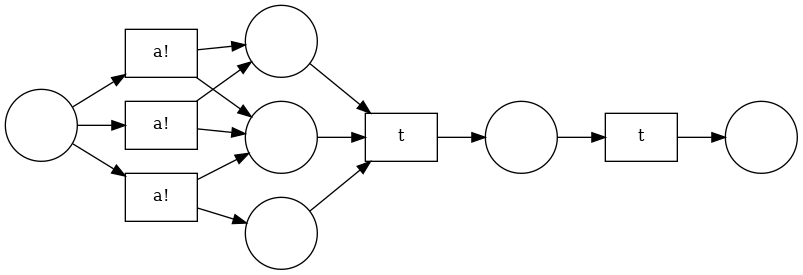

Processing Queue: 1620it [00:18, 309.43it/s]

In [14]:
assert not is_isomorphic(net, multiple_refined_net)

# check refinement algorithm
is_ref, path = is_refinement(ip1_net_a1, multiple_refined_net, TRANSFORMATIONS)
print("Output:", is_ref, path)  # noqa: T201

In [ ]:
# Check if refinement is possible
is_ref, path = is_refinement(ip1_net_a1, net, TRANSFORMATIONS)
print(is_ref, path)

#### 4. Check Algorithm


In [ ]:
# discovered net
discovered_net = compositional_discovery(
    input_log_path=log_path,
    algorithm=algorithm,
    interface_pattern=INTERFACE_PATTERNS[0],
    transformations=TRANSFORMATIONS,
)
pm4py.view_petri_net(discovered_net, format="png")

In [ ]:
# compositionally mined process model from paper
pn_coposition_mined, initial_marking, final_marking = pm4py.read_pnml(
    "/workspaces/university-petri-nets/backend/data_catalog/compositional_process_discovery_experiment_data/IP-1/IP-1_composition_mined.pnml",
)
pm4py.view_petri_net(pn_coposition_mined, initial_marking, final_marking, format="png")

#### 5. Conformance Checking


In [ ]:
df_log = pm4py.read_xes(log_path)

pm4py.check_soundness(net, initial_marking, final_marking)
pm4py.fitness_token_based_replay(df_log, net, initial_marking, final_marking)
pm4py.precision_token_based_replay(df_log, net, initial_marking, final_marking)
pm4py.conformance_diagnostics_alignments(df_log, net, initial_marking, final_marking)


In [ ]:
# alignment based fitness and precision
pm4py.fitness_alignments(df_log, net, initial_marking, final_marking)
pm4py.precision_alignments(df_log, net, initial_marking, final_marking)

In [ ]:
# entropy based fitness and precision
precision, recall = entropy_conformance(
    "/app/backend/data_catalog/compositional_process_discovery_experiment_data/IP-1/IP-1_initial_log.xes",
    "/app/backend/data_catalog/compositional_process_discovery_experiment_data/IP-1/IP-1_directly_mined.pnml",
)
print(f"Precision: {precision}, Recall: {recall}")